In [104]:
import sys
sys.path.append("..")
import torch
import torch_geometric as tg

import networkx as nx
import numpy as np

from torch_geometric.data import Data, Batch
from src.model.springmodel import SpringModel
from src.data_generater.spring import SpringSim

import matplotlib.pyplot as plt

from torchdiffeq import odeint

In [105]:
def batch(batch_size, n_balls=10, _delta_T=0.001):

    sample_freq = 100
    T = (10+batch_size)*sample_freq

    model = SpringSim(n_balls=n_balls, _delta_T=_delta_T)
    pos, vel, adj = model.sample_trajectory(T, sample_freq)
    # 模拟初始态的速度为0， 不宜采用作为训练输入
    # 故取中间（t=10）作为初始态
    pos = pos[10:]
    vel = vel[10:]
    adj = adj

    G = nx.from_numpy_array(adj)
    edge_index = torch.LongTensor(np.array(G.edges()).T)
    edge_index = tg.utils.to_undirected(edge_index)

    pos_0 = torch.Tensor(pos[0])
    vel_0 = torch.Tensor(vel[0])

    pos_res = torch.Tensor(pos[1:])
    vel_res = torch.Tensor(vel[1:])

    delta_t = torch.arange(batch_size)*(_delta_T*sample_freq)
    data = Data(num_nodes=n_balls,
                edge_index=edge_index, 
                pos_0=pos_0.transpose(0,1),
                pos_res=pos_res.transpose(1,2),
                vel_0=vel_0.transpose(0,1),
                vel_res=vel_res.transpose(1,2),
                delta_t=delta_t)
    return data

In [172]:
# args
cuda_id = "cuda:0"
pos_in_dim = 2
vel_in_dim = 2
edge_in_dim = 4
hid_dim = 64

In [226]:
device = torch.device(cuda_id)
model = SpringModel(pos_in_dim, edge_in_dim, vel_in_dim, hid_dim)
model = model.to(device)
model.load_state_dict(torch.load("../checkpoints/spring_base_model.pt"))
model.eval()

SpringModel(
  (pos_encoder): PositionEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (edge_encoder): EdgeEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (vel_encoder): VelocEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (process): Processer(
    (encoder): Sequential(
      (0): Linear(in_features=192, out_features=64, bias=True)
   

In [453]:
batch_size = 500
n_balls = 30

In [454]:
val_batch = batch(batch_size, n_balls=n_balls).to(device)

<ipython-input-454-3466b42efc7d>:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  val_batch = batch(batch_size, n_balls=n_balls).to(device)


In [455]:
model.edge_index = val_batch.edge_index
node_f = torch.cat((val_batch.pos_0, val_batch.vel_0), dim=1)
node_n = torch.cat((val_batch.pos_res, val_batch.vel_res), dim=2)
pred_node_n = odeint(func=model, y0=node_f, t=val_batch.delta_t, method="rk4")

In [456]:
pos_pred, vel_pred = pred_node_n[:, :, :2], pred_node_n[:, :, -2:]

In [457]:
pos_pred = pos_pred.detach().cpu().numpy()

In [458]:
pos_true = val_batch.pos_res.cpu().numpy()

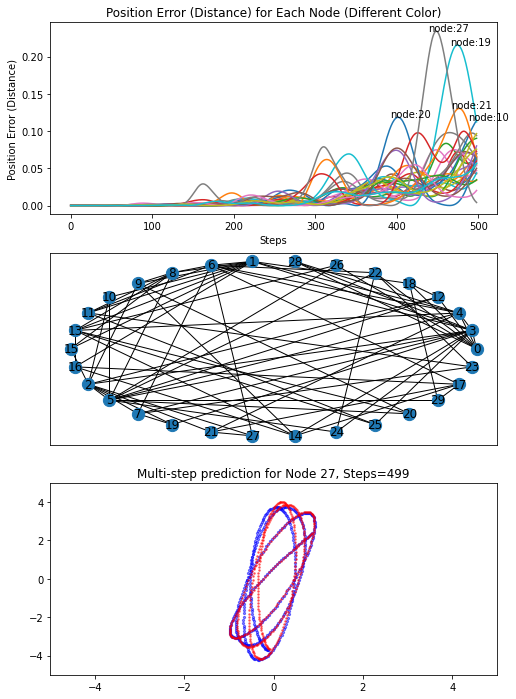

In [459]:
fig, ax = plt.subplots(3, figsize=(8,12))
# 画出每个节点的位置预测误差随时间的变化
distance_error = np.sum((pos_pred[1:] - pos_true)**2, axis=2)
ax[0].plot(distance_error)
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Position Error (Distance)")
ax[0].set_title("Position Error (Distance) for Each Node (Different Color)")

maxErrorPerNode = np.max(distance_error, axis=0)
nodeSortByError = np.argsort(maxErrorPerNode)[::-1]
text = {}
for n in nodeSortByError[:5]:
    node_seq = distance_error[:, n]
    step = np.where(node_seq==maxErrorPerNode[n])[0][0]
    ax[0].text(step-10, maxErrorPerNode[n], "node:{}".format(n))

# 画出背后的图
G = nx.Graph()
G.add_edges_from(val_batch.edge_index.T.detach().cpu().numpy())
nx.draw_networkx(G, pos=nx.layout.circular_layout(G), node_size =150, ax=ax[1])

# 画出所有节点的轨迹
for i in nodeSortByError[:1]:
    ax[2].scatter(pos_pred[1:, i, 0], pos_pred[1:, i, 1], s=5, c="b", alpha=0.5)
    ax[2].scatter(pos_true[:, i, 0], pos_true[:, i, 1], s=2.5, c="r", alpha=0.5)
ax[2].set_title("Multi-step prediction for Node {}, Steps={}".format(
    nodeSortByError[:1][0],pos_true.shape[0]))
ax[2].set_xlim([-5,5])
ax[2].set_ylim([-5,5])
plt.savefig("../figs/prediction_analysis_ode.pdf")
plt.show()